In [2]:
# tensorflow==2.10.1
# numpy==1.26.4
# matplotlib==3.8.3
# scikit-learn==1.4.2
# tensorflow-addons==0.22.0

import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings("ignore")
np.random.seed(0)
keras.utils.set_random_seed(0)

In [3]:
sample_size = 32 * 200
num_epochs = 500

# data
image_size = 128
plot_diffusion_steps = 50

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 32
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

In [4]:
path = "data0/lsun/bedroom/0"

DS = keras.preprocessing.image_dataset_from_directory(
    path,
    labels=None,
    batch_size=None,
    shuffle=False,
    seed=0,
    image_size=(image_size, image_size),
    validation_split=None,
).take(sample_size)

Found 19811 files belonging to 1 classes.


In [5]:
def rescale(img):
    img = tf.cast(img, dtype=tf.float32)
    img = img / 255.0
    img = tf.clip_by_value(img, 0, 1)
    return img

train_dataset = DS.map(rescale).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [6]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    log_min_freq = tf.math.log(embedding_min_frequency)
    log_max_freq = tf.math.log(embedding_max_frequency)
    frequencies = tf.exp(tf.linspace(log_min_freq, log_max_freq, embedding_dims // 2))
    angular_speeds = tf.cast(2.0 * math.pi * frequencies, dtype=tf.float32)
    sin_embeddings = tf.sin(angular_speeds * x)
    cos_embeddings = tf.cos(angular_speeds * x)
    embeddings = tf.concat([sin_embeddings, cos_embeddings], axis=-1)
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation="swish")(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding, output_shape=(1, 1, 32))(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")


class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = get_network(image_size, widths, block_depth)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.cast(tf.acos(max_signal_rate), dtype=tf.float32)
        end_angle = tf.cast(tf.acos(min_signal_rate), dtype=tf.float32)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, num_rows=3, num_cols=6, diffusion_steps=plot_diffusion_steps):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()

In [7]:
model = DiffusionModel(image_size, widths, block_depth)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
model.normalizer.adapt(train_dataset)

In [8]:
model.fit(
    train_dataset,
    epochs=50,
)

Epoch 1/50


200/200 [==============================] - 56s 246ms/step - n_loss: 0.2439 - i_loss: 0.5814
Epoch 2/50
200/200 [==============================] - 49s 245ms/step - n_loss: 0.1614 - i_loss: 0.3063
Epoch 3/50
200/200 [==============================] - 49s 246ms/step - n_loss: 0.1481 - i_loss: 0.2837
Epoch 4/50
200/200 [==============================] - 47s 237ms/step - n_loss: 0.1426 - i_loss: 0.2615
Epoch 5/50
200/200 [==============================] - 47s 236ms/step - n_loss: 0.1380 - i_loss: 0.2473
Epoch 6/50
200/200 [==============================] - 47s 235ms/step - n_loss: 0.1354 - i_loss: 0.2369
Epoch 7/50
200/200 [==============================] - 47s 236ms/step - n_loss: 0.1317 - i_loss: 0.2286
Epoch 8/50
 26/200 [==>...........................] - ETA: 41s - n_loss: 0.1302 - i_loss: 0.2231

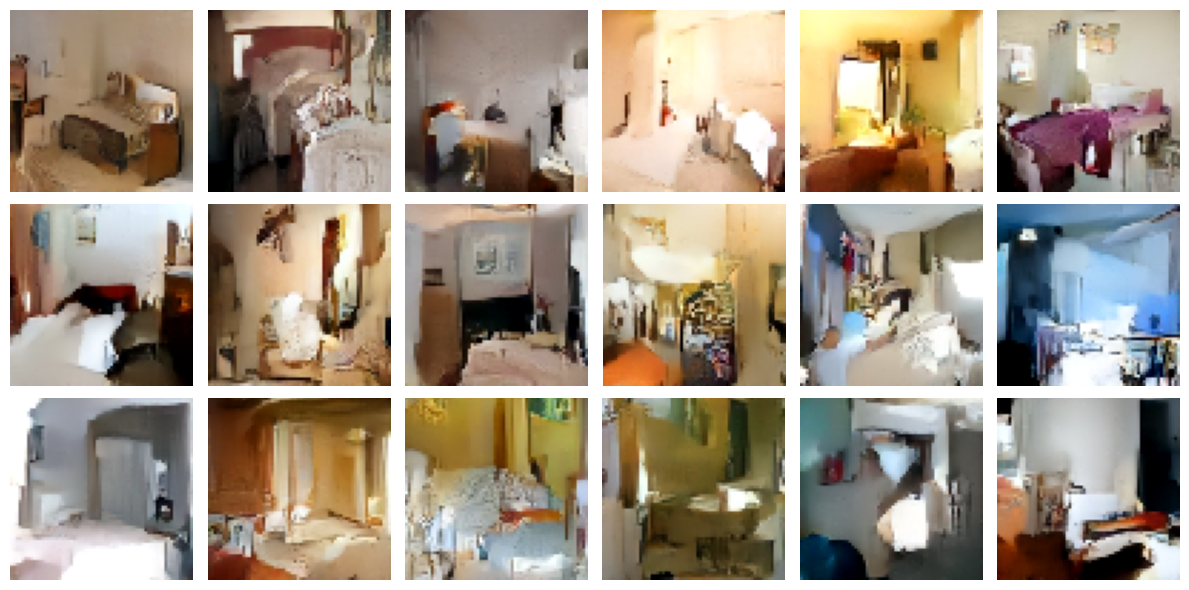

In [ ]:
model.plot_images()

In [ ]:
model.save_weights(f"ddim_{num_epochs}_{sample_size}.weights.tf")

In [9]:
# model.load_weights("ddim_100_1600.weights.tf")

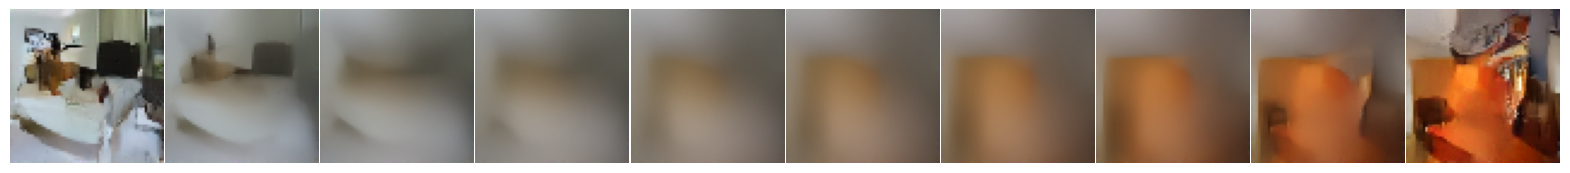

In [89]:
# latent_matrix1 = tf.random.normal(shape=(image_size, image_size, 3))
# latent_matrix2 = tf.random.normal(shape=(image_size, image_size, 3))

# interpolated_matrices = []
# for weight in tf.linspace(0.0, 1.0, 10):
#     interpolated_matrix = latent_matrix1 * (1 - weight) + latent_matrix2 * weight
#     interpolated_matrices.append(interpolated_matrix)

# interpolated_matrices = tf.stack(interpolated_matrices)

# generated_images = model.reverse_diffusion(interpolated_matrices, plot_diffusion_steps)
# generated_images = model.denormalize(generated_images)

# fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(20, 4))
# for i in range(10):
#     axs[i].imshow(generated_images[i])
#     axs[i].axis("off")

# plt.subplots_adjust(wspace=0.01)
# plt.show()

In [ ]:
# https://stackoverflow.com/questions/70719562/calculating-fid-scores-for-gan-models-between-two-different-image-directory
# https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

# from scipy.linalg import sqrtm
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_v3 import preprocess_input


# def calculate_fid(model, images1, images2):
#     act1 = model.predict(images1)
#     act2 = model.predict(images2)
#     mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
#     mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
#     ssdiff = np.sum((mu1 - mu2) ** 2.0)
#     covmean = sqrtm(sigma1.dot(sigma2))
#     if np.iscomplexobj(covmean):
#         covmean = covmean.real
#     fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
#     return fid

# model = InceptionV3(include_top=False, pooling="avg", input_shape=(image_size, image_size, 3))

# lsun_bedrooms = np.array([i.numpy() for i in DS])
# lsun_bedrooms1 = lsun_bedrooms[:5000]
# lsun_bedrooms2 = lsun_bedrooms[5000:10000]

# lsun_bedrooms1 = preprocess_input(lsun_bedrooms1)
# lsun_bedrooms2 = preprocess_input(lsun_bedrooms2)

# calculate_fid(model, lsun_bedrooms1, lsun_bedrooms2)